# Analysis of Optotagging Dataset
Evaluate ability of contrastive embeddings to separate cell types from extracellular waveforms

Dataset containing template waveforms of recorded units along with their putative cell types based on tuning to an optical simulus

## Load and inspect data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ceed
from tqdm import tqdm

In [2]:
#load data

path_to_files = '/home/noah/noah/allen/optotagging_ceed_dataset/'
#https://stackoverflow.com/questions/19201290/how-to-save-a-dictionary-to-a-file

#dictionaries are queried by 'cell type -> sessions_id -> waveforms and information'
tuned = np.load(path_to_files+'tuned.npy', allow_pickle=True).item()
non_tuned = np.load(path_to_files+'non_tuned.npy', allow_pickle= True).item()

In [3]:
tuned['Sst'][789848216].keys()

dict_keys(['waveforms', 'unit_ids', 'unit_position'])

In [9]:
num_waves = [tuned[cell_type][session_key]['waveforms'].shape[0] for cell_type in tuned for session_key in tuned[cell_type]]
num_waves_untuned = sum([non_tuned[cell_type][session_key]['waveforms'].shape[0] for cell_type in non_tuned for session_key in non_tuned[cell_type]])
print('number of tuned waveforms: ', sum(num_waves))
print('number of untuned waveforms: ', num_waves_untuned)

number of tuned waveforms:  294
number of untuned waveforms:  3868


## Manipulate Data into a more appropriate form for CEED

Create np arrays of extracted waveforms and their labels

Waveforms should have their peaks aligned at sample 42 (not implemented)

Wavefroms should be 121 samples long

In [18]:
#Waveforms and labels extracted into two numpy arrays

#could use a list of tuples?
waves = np.empty((sum(num_waves), 82))
labels = np.empty((sum(num_waves)), str)
i = 0
for celltype in tuned:
    
    for session in tuned[celltype]:
        session_waves = tuned[celltype][session]['waveforms']
        number_of_waves = session_waves.shape[0]
        
        waves[i:number_of_waves+i] = session_waves
        labels[i:number_of_waves+i] = celltype
        
        i += number_of_waves
        

waves_untuned = np.empty((num_waves_untuned, 82))
labels_untuned = np.empty((num_waves_untuned), str)
i = 0
for celltype in non_tuned:
    
    for session in tuned[celltype]:
        session_waves = non_tuned[celltype][session]['waveforms']
        number_of_waves = session_waves.shape[0]
        
        waves_untuned[i:number_of_waves+i] = session_waves
        labels_untuned[i:number_of_waves+i] = celltype
        
        i += number_of_waves 

In [19]:
#labels are converted from strings to integer labels
def convert_labels(x):
    if x == 'S':
        label = 0
    elif x == 'V':
        label = 1
    elif x == 'P':
        label = 2
    else:
        print(x)
    return label
    
vconvert = np.vectorize(convert_labels)
int_labels = vconvert(labels)
int_labels_untuned = vconvert(labels_untuned)

In [21]:
labels_untuned

array(['S', 'S', 'S', ..., 'P', 'P', 'P'], dtype='<U1')

### Upsample Waveforms to 121 samples

In [14]:
#manipulate waveforms
from tslearn.preprocessing import TimeSeriesResampler

def upsample(wave):
    spike_up = TimeSeriesResampler(sz=121).fit_transform([wave.tolist()])
    # spikes_test_wavemap_up = np.asarray(spikes_test_wavemap_up)
    return spike_up

upwaves = np.apply_along_axis(upsample, 1, waves).squeeze()
upwaves_untuned = np.apply_along_axis(upsample, 1, waves_untuned).squeeze()

(294, 121)
(3868, 121)


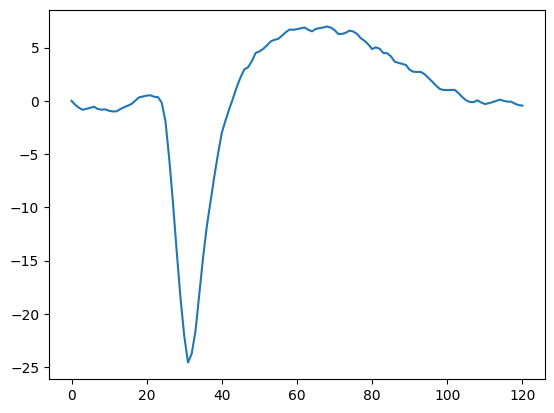

In [22]:
print(upwaves.shape)
print(upwaves_untuned.shape)
plt.plot(upwaves_untuned[0])
plt.show()

### Shift peak to sample number 42

Not implemented, unsure how to approach

In [23]:
upwaves[0].argmax()

49

## Create CEED embeddings of the waveforms in the dataset

In [24]:
#ignoring this, lets just ceed the data and move on
from ceed.models.ceed import CEED
import numpy as np
import os
import matplotlib.pyplot as plt
from analysis.projections import learn_manifold_umap, pca_train, pca
import colorcet as cc
import torch


2024-01-23 14:59:23.450630: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-23 14:59:23.707758: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-23 14:59:23.707828: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-23 14:59:23.752410: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-23 14:59:23.848161: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-23 14:59:23.849884: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [25]:
#normalize between -1 and 1 !

def normalize_wf(wf):
    """Normalize waveform for use in cell type experiments.
    Parameters
    ----------
    wf: numpy.ndarray
        spike that has shape (n_chans, spike_length_samples)
    Returns
    -------
    waveform normalized to the range [0, 1] to retain shape information, but not amplitude information
    """
    if len(wf.shape) == 1:
        _ = wf.shape
        n_chans = None
    else:
        n_chans, _ = wf.shape
    wf = wf.flatten()
    if np.max(np.abs(wf), axis=0) != 0:
        wf /= np.max(np.abs(wf), axis=0)
    wf = wf.reshape(n_chans, -1) if n_chans is not None else wf
    return wf


In [26]:
waveforms_normalised = np.empty_like(upwaves)
for i, wav in enumerate(upwaves):
    waveforms_normalised[i] = normalize_wf(wav)

waveforms_untuned_normalised = np.empty_like(upwaves_untuned)
for i, wav in enumerate(upwaves_untuned):
    waveforms_untuned_normalised[i] = normalize_wf(wav)

In [27]:
fc_celltype_ckpt_dir = '/home/noah/code/ceed_models/celltype/test'

fc_celltype_ceed_5d = CEED(num_extra_chans=0, out_dim=5, proj_dim=5, gpu=0, old_ckpt=True)
fc_celltype_ceed_5d.load(fc_celltype_ckpt_dir)

Using projector; batchnorm False with depth 3; hidden_dim=512
loading from previous checkpoint:  /home/noah/code/ceed_models/celltype/test


In [28]:
print(waveforms_normalised.shape)
batch = 1
cells = waveforms_normalised.shape[0]
timepoints = waveforms_normalised.shape[1]

print(waveforms_untuned_normalised.shape)
batch = 1
cells_untuned = waveforms_untuned_normalised.shape[0]
timepoints_untuned = waveforms_untuned_normalised.shape[1]

(294, 121)
(3868, 121)


In [29]:
waveforms_normalised = torch.from_numpy(waveforms_normalised.astype('float32')) #must be float32?
waveforms_normalised = waveforms_normalised.reshape(batch, int(cells/batch), timepoints)
# waveforms = waveforms.to('cuda') 

#put on the gpu in the inference loop?
#https://discuss.pytorch.org/t/dataset-location-runtimeerror-caught-runtimeerror-in-dataloader-worker-process-0/156842

print(waveforms_normalised.shape, waveforms_normalised.device)

torch.Size([1, 294, 121]) cpu


In [30]:
embeddings_all = []
with torch.no_grad():
    for spike in tqdm(waveforms_normalised):
        # data = torch.unsqueeze(spike, dim=-1)
        spike.to('cuda')
        feature = fc_celltype_ceed_5d.transform(spike) #returns a np array
        embeddings_all.append(feature)
# embeddings_all = torch.concatenate(embeddings_all).to('cpu').detach().squeeze().numpy()
embeddings_all = np.asarray(embeddings_all).squeeze()

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]


In [31]:
waveforms_normalised = np.asarray(waveforms_normalised.squeeze())

In [32]:
#now untuned

In [33]:
waveforms_untuned_normalised = torch.from_numpy(waveforms_untuned_normalised.astype('float32')) #must be float32?
waveforms_untuned_normalised = waveforms_untuned_normalised.reshape(batch, int(cells_untuned/batch), timepoints_untuned)
# waveforms = waveforms.to('cuda') 

#put on the gpu in the inference loop?
#https://discuss.pytorch.org/t/dataset-location-runtimeerror-caught-runtimeerror-in-dataloader-worker-process-0/156842

print(waveforms_untuned_normalised.shape, waveforms_untuned_normalised.device)

torch.Size([1, 3868, 121]) cpu


In [34]:
embeddings_all_untuned = []
with torch.no_grad():
    for spike in tqdm(waveforms_untuned_normalised):
        # data = torch.unsqueeze(spike, dim=-1)
        spike.to('cuda')
        feature = fc_celltype_ceed_5d.transform(spike) #returns a np array
        embeddings_all_untuned.append(feature)
# embeddings_all = torch.concatenate(embeddings_all).to('cpu').detach().squeeze().numpy()
embeddings_all_untuned = np.asarray(embeddings_all_untuned).squeeze()

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.49it/s]


In [35]:
waveforms_untuned_normalised = np.asarray(waveforms_untuned_normalised.squeeze())

In [36]:
embeddings_all_untuned.shape

(3868, 5)

In [37]:
embeddings_all.shape

(294, 5)

In [38]:
int_labels_untuned[:]=-1
int_labels_untuned

array([-1, -1, -1, ..., -1, -1, -1])

In [40]:
# print(embeddings_all_untuned_ds.shape)
# print(int_labels[int_labels==2].shape)

## Create a uniform dataset by removing units from over represented labels

This should be done earlier in the code eventually... now we are embedding waveforms just to remove them.

However, this allows for experimentation with the scaling of the data before clustering

In [42]:
# min count is 33 units for label 1

In [43]:
#reduce untuned cells:
x = 115 #downsample ratio
embeddings_all_untuned_ds = embeddings_all_untuned[::x]
int_labels_untuned_ds = int_labels_untuned[::x]
waveforms_untuned_normalised_ds = waveforms_untuned_normalised[::x]


In [44]:

#Reduce everything so equal numbers of each cell type are found...
embeddings_lab0 = embeddings_all[int_labels==0][::3]
waveforms_normalised_lab0 = waveforms_normalised[int_labels==0][::3]
labs0 = int_labels[int_labels==0][::3]
print(waveforms_normalised_lab0.shape)

embeddings_lab1 = embeddings_all[int_labels==1]
waveforms_normalised_lab1 = waveforms_normalised[int_labels==1]
labs1 = int_labels[int_labels==1]
print(labs1.shape)

embeddings_lab2 = embeddings_all[int_labels==2][::5]
waveforms_normalised_lab2 = waveforms_normalised[int_labels==2][::5]
labs2 = int_labels[int_labels==2][::5]
print(waveforms_normalised_lab2.shape)

# recombine
embeddings_all_ds = np.vstack([embeddings_lab0, embeddings_lab1, embeddings_lab2])
int_labs_ds = np.hstack([labs0, labs1, labs2])
waveforms_normalised_ds = np.vstack([waveforms_normalised_lab0, waveforms_normalised_lab1, waveforms_normalised_lab2])
waveforms_normalised_ds.shape


(32, 121)
(33,)
(34, 121)


(99, 121)

In [45]:
# combine
embeds = np.vstack([embeddings_all_ds, embeddings_all_untuned_ds])
labs = np.hstack([int_labs_ds, int_labels_untuned_ds])
all_waves = np.vstack([waveforms_normalised_ds, waveforms_untuned_normalised_ds])
print(embeds.shape)
print(labs.shape)
print(all_waves.shape)

(133, 5)
(133,)
(133, 121)


## Clustering

now the easy thing to do is cluster these embeddings with GMM :)
then use this as a map with the labels

In [48]:
from sklearn.mixture import GaussianMixture
import numpy as np

no_clusters = 15

labels = []
aic_scores = []
bic_scores = []
for num_clust in tqdm(np.arange(no_clusters)+1):
    gmm = GaussianMixture(num_clust, random_state=0).fit(embeds)
    gmm_labels = gmm.predict(embeds)
    bic_score = gmm.bic(embeds)
    aic_score = gmm.aic(embeds)
    labels.append(gmm_labels)
    bic_scores.append(bic_score)
    aic_scores.append(aic_score)

100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.87it/s]


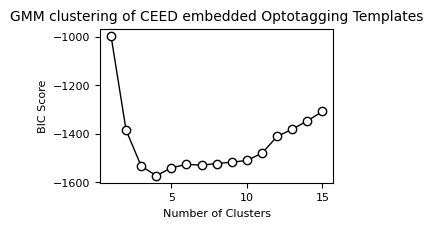

In [49]:
f, arr = plt.subplots()
f.set_size_inches(3., 2.)
arr.plot(np.arange(no_clusters) + 1, bic_scores,c='k', marker='o',fillstyle='full',markerfacecolor='w',linewidth=1,markeredgewidth=1)
plt.xlabel('Number of Clusters')
plt.ylabel('BIC Score')
plt.title('GMM clustering of CEED embedded Optotagging Templates')
plt.show()

In [50]:
no_clusters = 4

In [51]:
gmm = GaussianMixture(no_clusters, random_state=0).fit(embeds)
gmm_labels = gmm.predict(embeds)

In [52]:
templates_g = []
templates_lab = []
for label in np.unique(gmm_labels):
    templates_g.append(all_waves[gmm_labels==label])
    templates_lab.append(labs[gmm_labels==label])

In [53]:
templates_lab[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2, -1, -1,
       -1, -1, -1, -1])

## Display Results

Show how effective these clusters are at extracting different cell types


In [55]:
#color cet time, create a colout scheme :)

import colorcet as cc
def get_ccolor(k):
    if k == -1:
        return "#808080"
    else:
        return ccolors[k % len(ccolors)]
# ccolors = cc.glasbey[:31]
ccolors = cc.glasbey[:3]

cols = [get_ccolor(idx) for idx in unique]

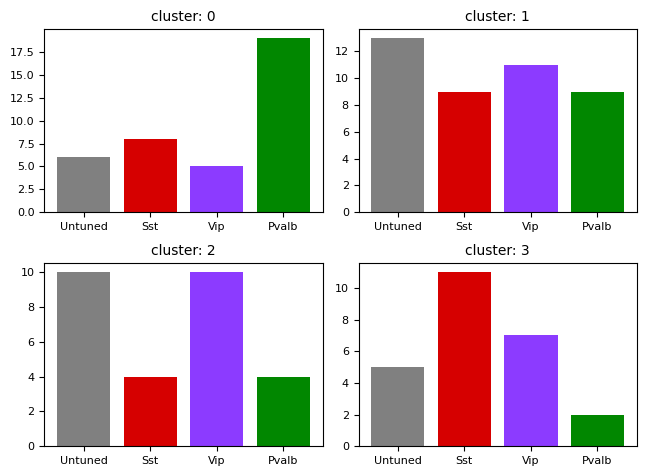

In [56]:
fig, ax = plt.subplots(2,2)
for i, cluster in enumerate(templates_lab):
    unique, counts = np.unique(cluster, return_counts=True)
    if i <= 1:
        j = 0
        k = i
    else:
        j = 1
        k = i-2
        
    ax[j,k].bar(unique, counts, tick_label = ['Untuned', 'Sst', 'Vip', 'Pvalb'], color = cols)
    ax[j,k].set_title('cluster: ' + str(i))
fig.tight_layout()
plt.show()

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 73.15it/s]


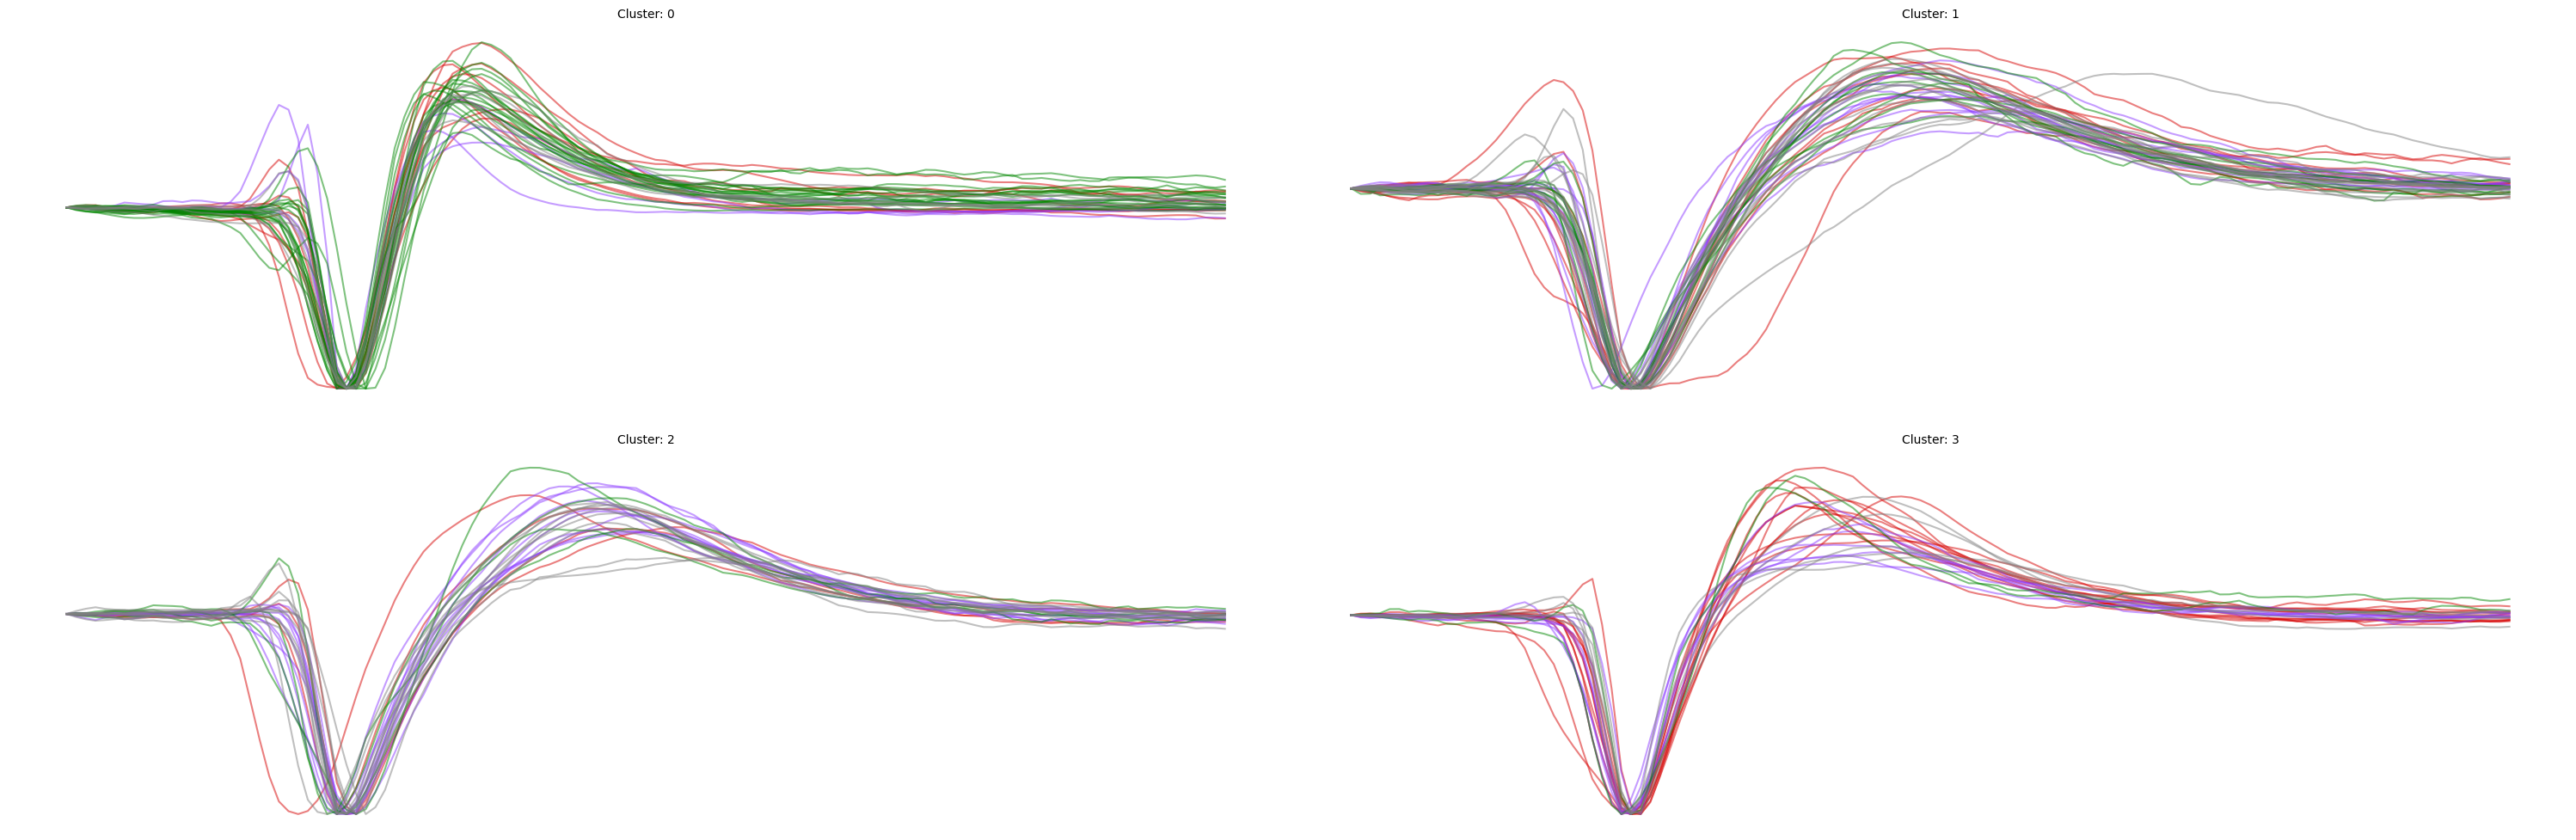

In [59]:
fig, ax = plt.subplots(2,2, figsize = (30,10))

for i in tqdm(range(no_clusters)):
    if i < 2:
        j = 0
        k = i
    # elif 5 <= i < 10:
    #     j = 1
    #     k = i-5
    else:
        j = 1
        k = i-2
        
    for c, wave in enumerate(templates_g[i]):
        ax[j,k].plot(wave, alpha=.5, color=get_ccolor(templates_lab[i][c]))
        ax[j,k].set_title('Cluster: ' + str(i))
    # ax[j,k].plot(np.mean(templates_g[i], 0), alpha=1, color = 'c')

for a in ax.ravel():
    a.set_axis_off()
    
fig.tight_layout(h_pad=3)
plt.subplots_adjust(top=0.95)

import matplotlib.lines as mlines


fig.show()

In [61]:
# for i in range(no_clusters):
#     for wave in templates_g[i]:
#         plt.plot(wave, alpha=.05, color='k')
#     plt.plot(np.mean(templates_g[i], 0), alpha=1, color = 'c')
#     plt.show()


In [62]:
#now look at the labels!
# run pca on embeddings, colour by label, colour by truth...
embeds.shape

(133, 5)

In [63]:
# combine
embedspca = np.vstack([embeddings_all, embeddings_all_untuned_ds])
labspca = np.hstack([int_labels, int_labels_untuned_ds])
# all_waves = np.vstack([waveforms_normalised_ds, waveforms_untuned_normalised_ds])
print(embedspca.shape)
print(labspca.shape)


(328, 5)
(328,)


In [64]:
from sklearn.decomposition import PCA 
pca = PCA(n_components=2)
pca.fit(embedspca)

PCA(n_components=2)

In [65]:
print(pca.explained_variance_ratio_)

[0.88271284 0.07513323]


In [66]:
dr_embeds = pca.transform(embedspca)

In [67]:
dr_embeds.shape

(328, 2)

Text(0.5, 1.0, 'PCA Projection of CEED Embeddings')

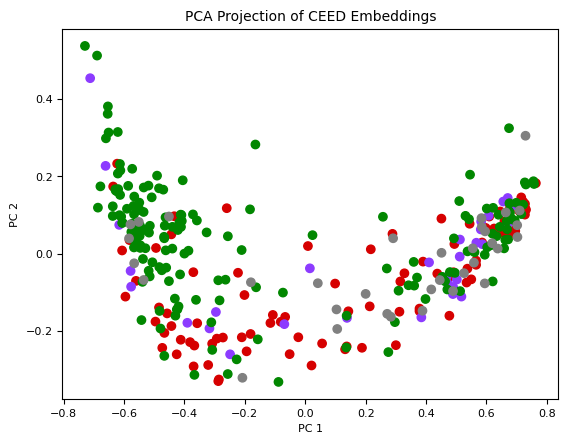

In [68]:
cols_pca = [get_ccolor(idx) for idx in labspca]
plt.scatter(dr_embeds[:,0], dr_embeds[:,1], c = cols_pca)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA Projection of CEED Embeddings')

# ToDo:

1. check if genetic line is actually a better explanation of the clustering (opposed to cell type)
2. get single spike waveforms and repeat
3. align spikes properly
4. make a fake dataset from wildtype and see if that clusters at all...
5. umap plot of clusters
6. predict cell type from embeddings and test accuracy
7. test PCA vs handpicked labels vs CEED embeddings

